# The purpose of this notebook is to present a minimal-working example of wavenet. 

In [2]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

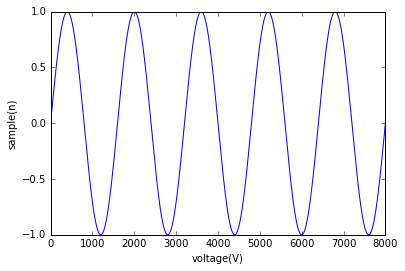

In [3]:
% matplotlib inline
Fs = 8000
f = 5
sample = 8000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y)
plt.xlabel('voltage(V)')
plt.ylabel('sample(n)')
plt.show()

In [7]:
type(y)

numpy.ndarray

In [8]:
inputs = y

In [ ]:
# some of the pieces of code are taken from here
# https://github.com/ibab/tensorflow-wavenet/blob/master/wavenet/model.py
class ToyWeveNet(object):
    def __init__(self, batch_size, filter_width, quantization_channel=2**4, dilations, dilation_channels)
        self.filter_width = filter_width
        self.quantization_channel = quantization_channel #  number of entries in one-hot encoding of inputs
        self.dilations = dilations # A list with the dilation factor for each layer
        self.dilation_channels = dilation_channels  # dilation_channels: How many filters to learn for the dilated convolution.
        
        self.variables = self._create_variables() # will create all variables for this model (i.e. weights for each layer )

    def _create_variables(self):
        '''This function creates all variables used by the network.
        This allows us to share them between multiple calls to the loss
        function and generation function.'''

        var = dict()

        with tf.variable_scope('wavenet'):
            with tf.variable_scope('causal_layer'):
                layer = dict()

                initial_channels = self.quantization_channels
                initial_filter_width = self.filter_width
                
                layer['filter'] = create_variable(
                    'filter',
                    [initial_filter_width,
                     initial_channels])
                     # self.residual_channels]) # when do we need this? Check the paper later
                var['causal_layer'] = layer

            var['dilated_stack'] = list()
            with tf.variable_scope('dilated_stack'):
                for i, dilation in enumerate(self.dilations):
                    with tf.variable_scope('layer{}'.format(i)):
                        current = dict()
                        current['filter'] = create_variable(
                            'filter',
                            [self.filter_width,
                             # self.residual_channels,
                             self.dilation_channels])
                        current['gate'] = create_variable(
                            'gate',
                            [self.filter_width,
                             # self.residual_channels,
                             self.dilation_channels])
                        current['dense'] = create_variable(
                            'dense',
                            [1,
                             # self.dilation_channels,
                             self.residual_channels])
                        if self.use_biases:
                            current['filter_bias'] = create_bias_variable(
                                'filter_bias',
                                [self.dilation_channels])
                            current['gate_bias'] = create_bias_variable(
                                'gate_bias',
                                [self.dilation_channels])
                            current['dense_bias'] = create_bias_variable(
                                'dense_bias',
                                [self.residual_channels])

                        var['dilated_stack'].append(current)

            with tf.variable_scope('postprocessing'): 
                # The reason why there are postprocess1 and 2 b/c there are two conv1x1 layers 
                # in the postprocessing session
                current = dict()
                current['postprocess1'] = create_variable(
                    'postprocess1',
                    [1, self.skip_channels, self.skip_channels]) 
                current['postprocess2'] = create_variable(
                    'postprocess2',
                    [1, self.skip_channels, self.quantization_channels])
                if self.use_biases:
                    current['postprocess1_bias'] = create_bias_variable(
                        'postprocess1_bias',
                        [self.skip_channels])
                    current['postprocess2_bias'] = create_bias_variable(
                        'postprocess2_bias',
                        [self.quantization_channels])
                var['postprocessing'] = current

        return var

    def _create_network(self, input_batch):
        '''Construct the WaveNet network.'''
        outputs = []
        current_layer = input_batch

        # Pre-process the input with a regular convolution
        initial_channels = self.quantization_channels # one-hot encoding on raw waveform

        current_layer = self._create_causal_layer(
            current_layer,
            initial_channels)
        
        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = self._create_dilation_layer(
                        current_layer, layer_index, dilation,
                        self.residual_channels, self.dilation_channels,
                        self.skip_channels)
                    outputs.append(output)

# reference

http://musyoku.github.io/2016/09/18/wavenet-a-generative-model-for-raw-audio/

https://github.com/ibab/tensorflow-wavenet/blob/master/wavenet/model.py